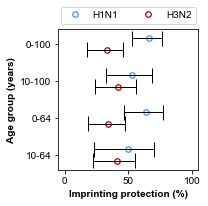

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splev, splrep
import numpy as np
from matplotlib import rcParams, colors
import seaborn as sns
%matplotlib inline

rcParams['font.sans-serif'] = 'arial'
plot_params = {'markersize': 5.5,
               'markeredgewidth': 1.2,
               'color': 'white'}
pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()
h1color=pal[0]
h3color=pal[1]

def get_param(imprinting_file, param, group_name):
    df = pd.read_csv(imprinting_file).dropna()
    df['CI_upper'] = df.prof_max
    df['CI_lower'] = df.prof_min
    df.index = df.param
    df['group_name'] = group_name
    param_values = df.loc[param, :]
    return param_values

# Plotting H1N1 results. Profiles are required to make these plots.
all_ages = get_param('../final_results_for_ms/0-100/DAHVage_subtype.profile_liks.csv', 'H1m', '0-100')
exclude_kids = get_param('../final_results_for_ms/10-100/DAHVage_subtype.profile_liks.csv', 'H1m', '10-100')
exclude_adults = get_param('../final_results_for_ms/0-64/DAHVage_subtype.profile_liks.csv', 'H1m', '0-64')
middle_ages = get_param('../final_results_for_ms/10-64/DAHVage_subtype.profile_liks.csv', 'H1m', '10-64')
plotdf = pd.DataFrame([all_ages, exclude_kids ,exclude_adults, middle_ages])
yval = -0.15
for index, row in plotdf.iterrows():
    label = row.group_name
    plt.plot([row.mle * 100], [-yval], 'o', **plot_params, markeredgecolor=h1color, zorder=1)
    plt.hlines(y=-yval, xmin=row.CI_lower*100, xmax=row.CI_upper*100, linewidth=1)
    plt.vlines(x=row.CI_lower*100, ymin=-yval-0.2, ymax=-yval+0.2, linewidth=1)
    plt.vlines(x=row.CI_upper*100, ymin=-yval-0.2, ymax=-yval+0.2, linewidth=1)

    yval += 1
    
# Plotting H3N2 results. Profiles are required to make these plots.
all_ages = get_param('../final_results_for_ms/0-100/DAHVage_subtype.profile_liks.csv', 'H3m', '0-100')
exclude_kids = get_param('../final_results_for_ms/10-100/DAHVage_subtype.profile_liks.csv', 'H3m', '10-100')
exclude_adults = get_param('../final_results_for_ms/0-64/DAHVage_subtype.profile_liks.csv', 'H3m', '0-64')
middle_ages = get_param('../final_results_for_ms/10-64/DAHVage_subtype.profile_liks.csv', 'H3m', '10-64')
plotdf = pd.DataFrame([all_ages,exclude_kids,exclude_adults,middle_ages])
yval = 0.15
for index, row in plotdf.iterrows():
    label = row.group_name
    plt.plot([row.mle * 100], [-yval], 'o', **plot_params, markeredgecolor=h3color, zorder=1)
    plt.hlines(y=-yval, xmin=row.CI_lower * 100, xmax=row.CI_upper*100, linewidth=1)
    plt.vlines(x=row.CI_lower * 100, ymin=-yval-0.2, ymax=-yval+0.2, linewidth=1)
    plt.vlines(x=row.CI_upper * 100, ymin=-yval-0.2, ymax=-yval+0.2, linewidth=1)
    yval += 1

yval = 0
yticks = []
ylabs = []
for index, row in plotdf.iterrows():
    label = row.group_name
    yticks.append(yval)
    ylabs.append(label)
    yval += -1
    
plt.plot([100], [100], 'o', **plot_params, markeredgecolor=h1color, label='H1N1')
plt.plot([100], [100], 'o', **plot_params, markeredgecolor=h3color, label='H3N2')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.yticks(yticks,ylabs)
plt.ylabel('Age group (years)', weight='bold')
plt.xlabel('Imprinting protection (%)', weight='bold')
plt.xlim(-5, 105)
plt.ylim(-3.4, 0.4)

plt.gcf().set_size_inches(3, 3)
plt.tight_layout()
plt.savefig('../../Marshfield/Flu-A-imprinting-paper/Fig_imprinting_estimates.pdf', bbox_inches='tight')

# Extrapolating the starts and ends of seasons

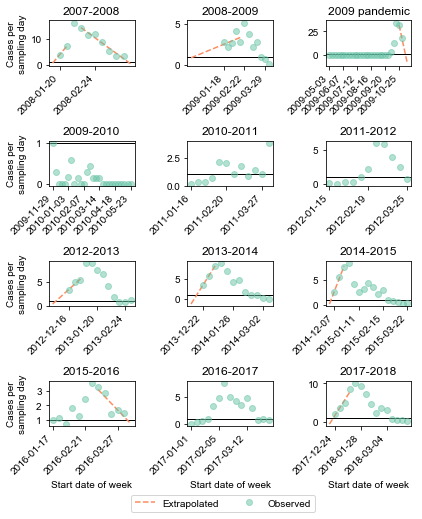

In [39]:
import pandas as pd
from dateutil import relativedelta
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pymmwr
from scipy import stats
import seaborn as sns
%matplotlib inline

rcParams['font.sans-serif'] = 'arial'
cases_per_sampling_day = pd.read_csv('../raw_data/cases_per_sampling_day.csv')

age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

def dominant_subtype(year):
    if year in ['2009', '2009Pan', '2010', '2014', '2016']:
        subtypes = ['H1N1', 'H1N1pdm']
    else:
        subtypes = ['H3N2']
    return subtypes

def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65+'
    return age_class

def season_to_season_float(season_str):
    if season_str == '2009Pan':
        s = 2009.5
    else:
        s = float(season_str)
    return s

def event_date_to_season_week(date):
    event = datetime.strptime(date, '%Y-%m-%d').date()
    mmwr_date = pymmwr.date_to_epiweek(event)
    epiweek = pymmwr.Epiweek(mmwr_date.year, mmwr_date.week)
    return pymmwr.epiweek_to_date(epiweek)

subplot_index = {'2008': 1,
                 '2009': 2,
                 '2009Pan': 3,
                 '2010': 4,
                 '2011': 5,
                 '2012': 6,
                 '2013': 7,
                 '2014': 8,
                 '2015': 9,
                 '2016': 10,
                 '2017': 11,
                 '2018': 12}


seasons_to_extrapolate = ['2013', '2014', '2009', '2008', '2015', '2018']
cases_per_sampling_day['Week'] = pd.to_datetime(cases_per_sampling_day['Week'])
cases_to_add = []

pal = sns.color_palette('Set2').as_hex()
fig, axes = plt.subplots(nrows=4, ncols=3)
axes = axes.flatten()



for season, seasondf in cases_per_sampling_day.groupby('Season'):
    subplot = subplot_index[season] - 1
    if season in seasons_to_extrapolate:
        plt.sca(axes[subplot])
        
        plotdf = seasondf.copy()
        plotdf.index = plotdf.Week
        plotdf = plotdf.fillna(0)
        peak_week = plotdf[plotdf['Cases per sampling day'] == max(plotdf['Cases per sampling day'])].index[0]
        data_subset = plotdf[plotdf.Week < peak_week].copy()
        x = [date.toordinal() for date in data_subset.Week]
        y = list(data_subset['Cases per sampling day'])
        m, b, r, p, e = stats.linregress(x, y)
        x0 = min(x)
        y0 = y[0]
        new_x = [datetime.fromordinal(X) for X in x]
        new_y = [m * X + b for X in x]
        case_extrap = []
        while y0 > 1:
            x0 = x0 - 7
            y0 = m * x0 + b
            x_test = pymmwr.date_to_epiweek(datetime.fromordinal(x0).date())
            new_x.append(datetime.fromordinal(x0))
            new_y.append(y0)
            
            case_extrap.append([x_test.year, x_test.week, np.ceil(y0 * 7)])
        case_extrap = pd.DataFrame(case_extrap, columns=['Year', 'Week', 'Cases'])
        new_x, new_y = zip(*sorted(zip(new_x, new_y)))
        plt.plot(new_x, new_y, '--', color=pal[1], label='Extrapolated')
        cases_to_add.append([season, 'start', case_extrap[case_extrap.Cases >0].sum().Cases])
        
# extrapolate ends
seasons_to_extrapolate = ['2008','2009Pan','2016']
for season, seasondf in cases_per_sampling_day.groupby('Season'):
    subplot = subplot_index[season] - 1
    plt.sca(axes[subplot])
    if season in seasons_to_extrapolate:
        
        
        plotdf = seasondf.copy()
        plotdf.index = plotdf.Week
        plotdf = plotdf.fillna(0)
        peak_week = plotdf[plotdf['Cases per sampling day'] == max(plotdf['Cases per sampling day'])].index[0]
        data_subset = plotdf[plotdf.Week > peak_week].copy()

        x = [date.toordinal() for date in data_subset.Week]
        y = list(data_subset['Cases per sampling day'])
    
        
        m, b, r, p, e = stats.linregress(x, y)
        x0 = max(x)
        y0 = y[-1]
        new_x = [datetime.fromordinal(X) for X in x]
        new_y = [m * X + b for X in x]
        case_extrap = []
        while y0 > 1:
            x0 = x0 + 7
            y0 = m * x0 + b
            x_test = pymmwr.date_to_epiweek(datetime.fromordinal(x0).date())
            new_x.append(datetime.fromordinal(x0))
            new_y.append(y0)
            
            case_extrap.append([x_test.year, x_test.week, np.ceil(y0 * 7)])
        case_extrap = pd.DataFrame(case_extrap, columns=['Year', 'Week', 'Cases'])
        new_x, new_y = zip(*sorted(zip(new_x, new_y)))
        plt.plot(new_x, new_y, '--', color=pal[1], label='Extrapolated')
        cases_to_add.append([season, 'end', case_extrap[case_extrap.Cases >0].sum().Cases])
        plt.ylabel('')
        plt.xlabel('')

for season, seasondf in cases_per_sampling_day.groupby('Season'):
    subplot = subplot_index[season] - 1
    plt.sca(axes[subplot])
    plotdf = seasondf.copy()
    plotdf.index = plotdf.Week
    plotdf = plotdf.fillna(0)
    new_x = [datetime.strptime(str(d).split()[0], '%Y-%m-%d') for d in plotdf['Week']]
    plt.plot(new_x, plotdf['Cases per sampling day'], 
             'o', color=pal[0], alpha=0.5, label='Observed')
    plt.ylabel('Cases per day')
    
    if season != '2009Pan':
        plt.title(str(int(season) - 1) + '-' + season)
    else:
        plt.title('2009 pandemic')
    plt.axhline(1, linestyle='-', linewidth=1, color='black', zorder=1)
    #plt.draw()
    #ticks, labels = plt.xticks()
    #plt.xticks(ticks, labels, rotation=45, ha='right', size=8)
    plt.xticks([new_x[int(i)] for i in range(0, len(new_x), 5)],
               [datetime.strftime(new_x[int(i)], '%Y-%m-%d') for i in range(0, len(new_x), 5)],
               rotation=45,
               ha='right')
    
    if subplot in [9, 10, 11]:
        plt.xlabel('Start date of week')
    else:
        plt.xlabel('')
        
    if subplot in [0, 3, 6, 9]:
        plt.ylabel('Cases per\nsampling day')
    else:
        plt.ylabel('')
        
plt.gcf().align_labels()        
plt.gcf().set_size_inches(6, 7)     
plt.tight_layout()
plt.legend(loc='center', bbox_to_anchor=(-1.2, -1.7), ncol=2)

# Output extrapolated cases for sensitivity analyses
outdf = pd.DataFrame(cases_to_add, columns=['Season','Period','Cases'])
outdf.to_csv('../data/extrapolated_case_totals.csv')

# Sensitivity to start and end of season

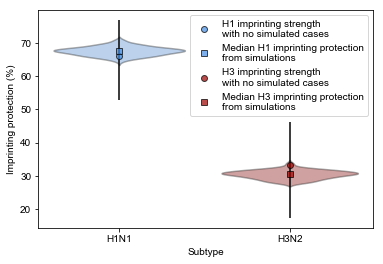

In [6]:
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import numpy as np
%matplotlib inline

df = pd.read_csv('../final_results_for_ms/0-100/sensitivity_summary.csv')
result = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype.profile_liks.csv', index_col='param')

pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()
rcParams['font.sans-serif'] = 'arial'


H1_mle = result.loc['H1m', 'mle']
H3_mle = result.loc['H3m', 'mle']
new_rows = []
for index, row in df.iterrows():
    new_rows.append(['H1N1', row.H1m * 100])
    new_rows.append(['H3N2', row.H3m * 100])
plotdf = pd.DataFrame(new_rows, columns=['Subtype', 'Imprinting protection (%)'])

sns.set_palette(pal)
sns.violinplot(data=plotdf, x='Subtype', y='Imprinting protection (%)', alpha=0.2, inner=None)

plt.setp(plt.gca().collections, alpha=0.4)
plt.plot([0], [H1_mle * 100], 'o', markeredgecolor='black', label='H1 imprinting strength\nwith no simulated cases',
         alpha=0.7)
plt.plot([0],
         [np.median(plotdf[plotdf.Subtype=='H1N1']['Imprinting protection (%)'])],
         's',
         markeredgecolor='black',
         label='Median H1 imprinting protection\nfrom simulations',
         alpha=0.7,
         color=pal[0])

plt.vlines(x=0, ymin=result.loc['H1m', 'prof_min'] * 100, ymax=result.loc['H1m', 'prof_max'] * 100)
plt.plot([1], [H3_mle * 100], 'o', markeredgecolor='black', label='H3 imprinting strength\nwith no simulated cases', alpha=0.7)
plt.plot([1],
         [np.median(plotdf[plotdf.Subtype=='H3N2']['Imprinting protection (%)'])],
         's',
         markeredgecolor='black',
         label='Median H3 imprinting protection\nfrom simulations',
         alpha=0.7,
         color=pal[1])
plt.vlines(x=1, ymin=result.loc['H3m', 'prof_min'] * 100, ymax=result.loc['H3m', 'prof_max'] * 100)
plt.legend()
plt.savefig('../../Marshfield/Flu-A-imprinting-paper/Fig_sensitivity.pdf', bbox_inches='tight')